## Text Detection & Recognition Pipeline with DETR and TROCR

This notebook demonstrate the function of the system.

I built a pipeline with the DETR ats input and TROC as output

In other words, the pipeline is the following:

* Load a full image with cursive or handwritten text
* Feed the DETR with the pixel values of the image
* Generate the bounding boxes from the image
* Crop the base image in "N" sub-images, where "N" is the number of boxes generated
* For every sub-image, feed the TROCR with the pixel values
* Generate the corresponding text for every sub-image
* Save pairs of "image" and "text" from inference

The results can be watched accesing the corresponding index of the lists

In [1]:
from transformers import DetrForObjectDetection, DetrImageProcessor, TrOCRProcessor, VisionEncoderDecoderModel
import torch
import cv2
import supervision as sv
from PIL import Image

2024-07-03 14:51:09.694520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 14:51:10.602789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DETR_CHECKPOINT = "/home/ralvarez22/Documentos/trocr_hand/trocr_llm/finetuned/detr/Akivili/V_2"
TROCR_MODEL = "/home/ralvarez22/Documentos/trocr_hand/trocr_llm/finetuned/Akivili/V_5"
DEVICE = "cuda"
CONFIDENCE_TRESHOLD = 0.7
IOU_TRESHOLD = 0.8
TEST_IMAGE = "/home/ralvarez22/Documentos/trocr_hand/trocr_llm/demo/detr_ocr_demo.jpeg"

In [4]:
detr_proc = DetrImageProcessor.from_pretrained(DETR_CHECKPOINT)
detr_model = DetrForObjectDetection.from_pretrained(
    pretrained_model_name_or_path=DETR_CHECKPOINT, 
    ignore_mismatched_sizes=True, local_files_only=True
).to(DEVICE)

trocr_proc = TrOCRProcessor.from_pretrained(TROCR_MODEL,device_map=DEVICE)
trocr_model = VisionEncoderDecoderModel.from_pretrained(TROCR_MODEL, device_map=DEVICE)
# Similar to the TROCR Lab, I force the parameters to avoid mistakes
trocr_model.generation_config.decoder_start_token_id = trocr_proc.tokenizer.bos_token_id
trocr_model.generation_config.temperature = 0.4

In [5]:
#Load the base image with PIL
original_image = Image.open(TEST_IMAGE).convert("RGB")

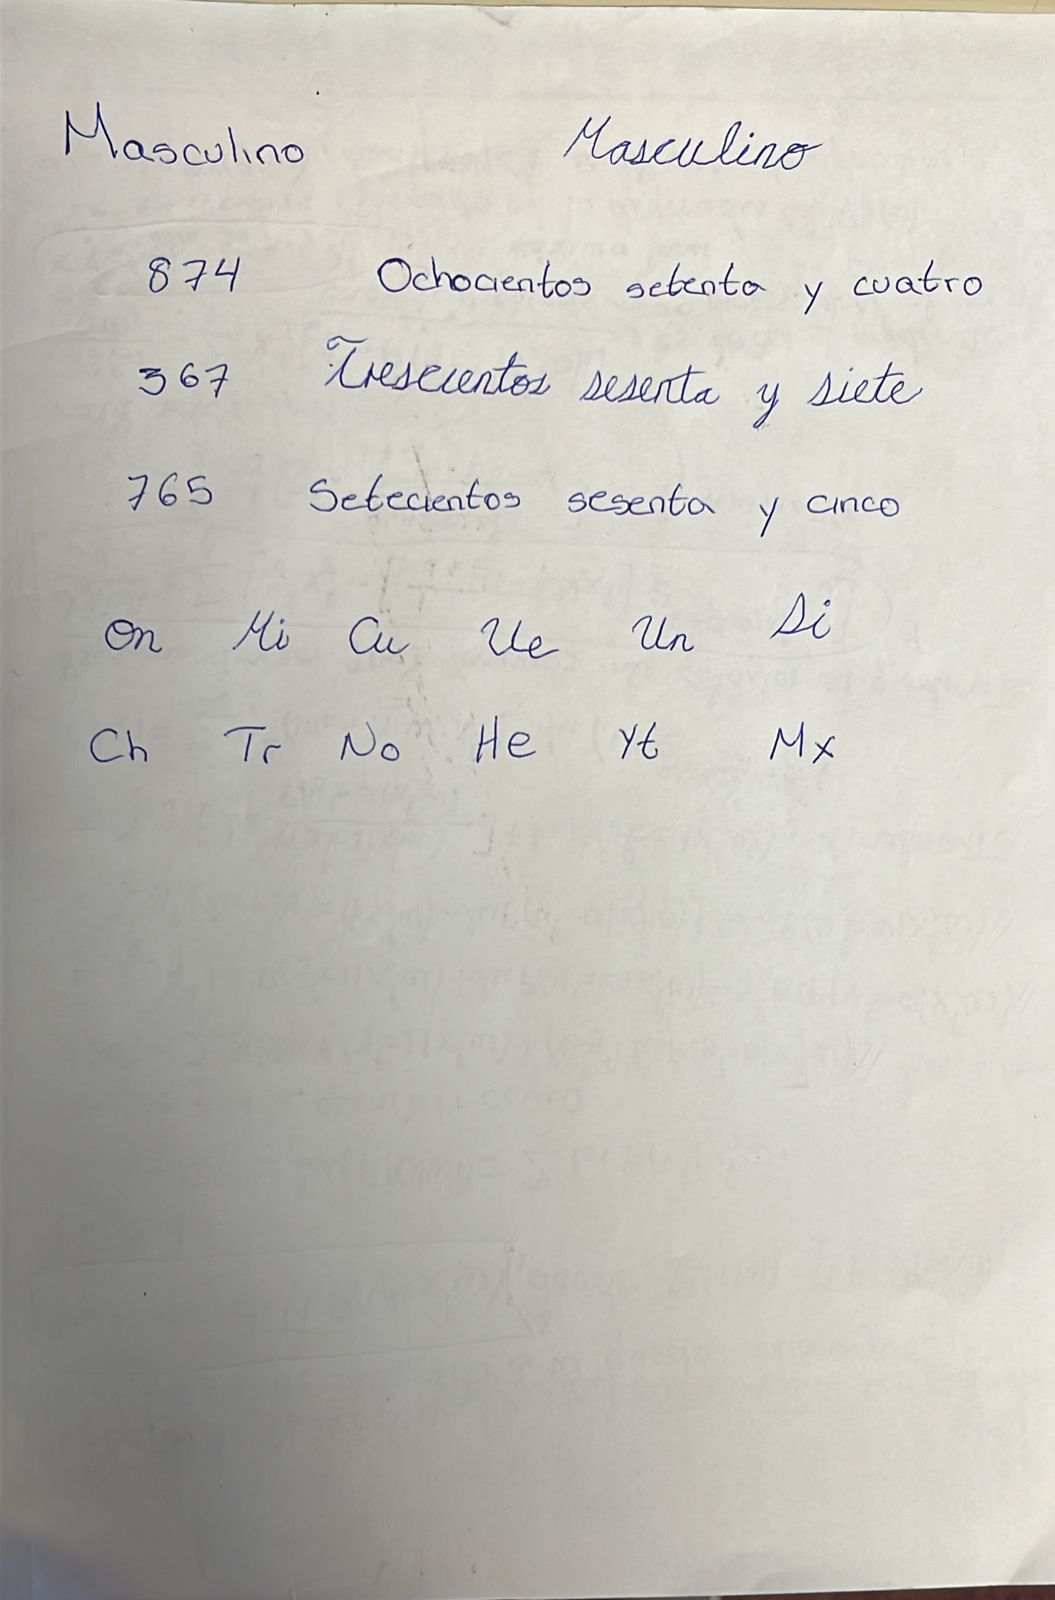

In [6]:
original_image

In [7]:
image = cv2.imread(TEST_IMAGE)

In [8]:
# Generate all the Bounding boxes
with torch.no_grad():

    # load image and predict
    inputs = detr_proc(images=image, return_tensors='pt').to(DEVICE)
    outputs = detr_model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = detr_proc.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

In [9]:
# Save the results in 2 lists
scores = results["scores"].tolist()
bboxes = results["boxes"].tolist()

detections


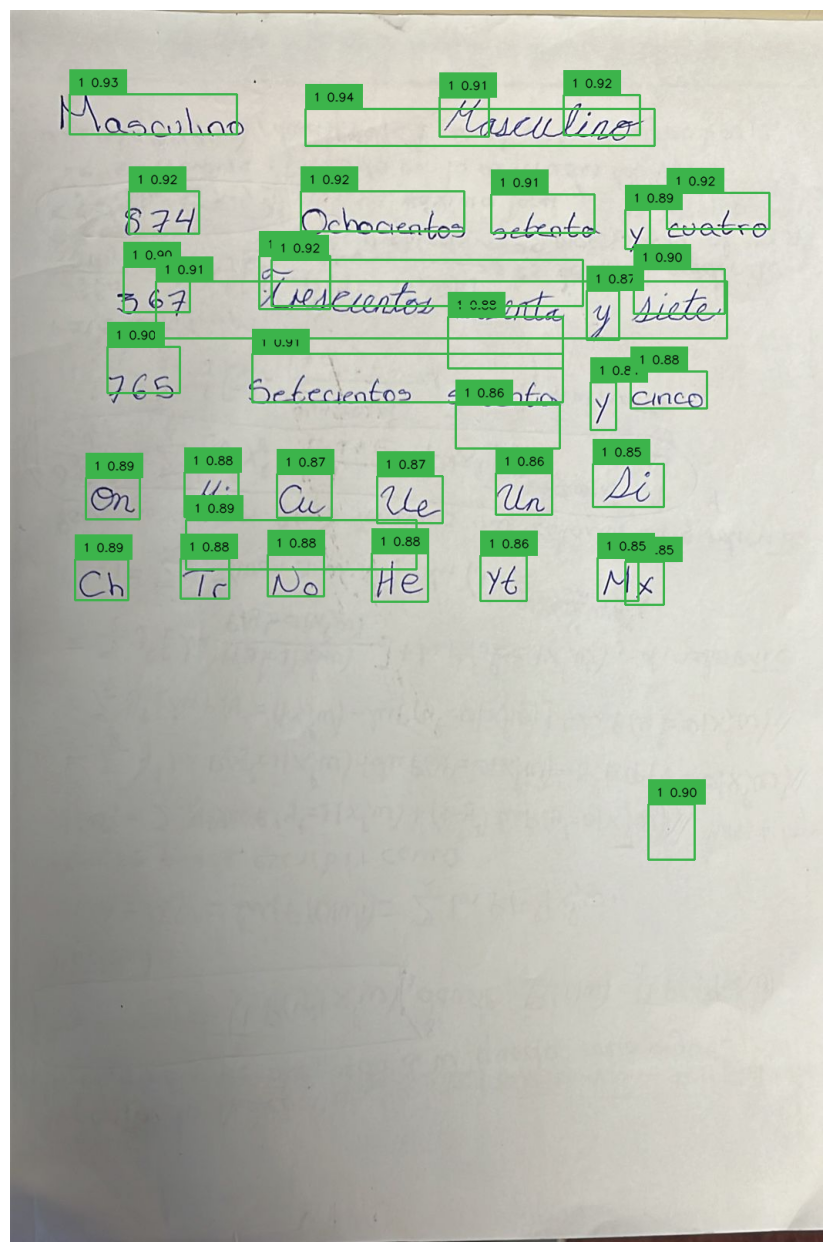

In [10]:
# Annotate the original image
box_annotator = sv.BoxAnnotator()
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.2)
labels = [f"{class_id} {confidence:.2f}" for _,_, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline  
sv.plot_image(frame, (16, 16))

In [11]:
# For every box, crop the base image and try to detect the text
detected_data = []
for idx, e in enumerate(bboxes):
    crp_img = original_image.crop(e)
    trocr_pixels = trocr_proc(crp_img, return_tensors="pt").pixel_values.to(DEVICE)
    trocr_out = trocr_model.generate(trocr_pixels)
    rec_text = trocr_proc.tokenizer.decode(trocr_out[0].cpu(), skip_special_tokens=True)
    detected_data.append((crp_img, rec_text))

/home/ralvarez22/server/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:533: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/ralvarez22/server/lib/python3.11/site-packages/transformers/generation/utils.py:1201: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


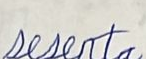

In [12]:
# ( PIL.Image, generated_text )
detected_data[60][0]

In [13]:
detected_data[60][1]

'sesenta'